Prelucrarea unei imagini si generarea unei baze de date pentru recunoasterea scrisului de mana 
Solutie economica, destinata integrarii 

Lucrarile 1 si 2 - Lab ICI  Inteligenta Computationala Integrata an IVA ETTI 
Ultima revizie: 30 ian. 2020 
Copyright Radu DOGARU 

# LUCRAREA 1 - SEGMENTAREA IMAGINILOR CU EXTRAGEREA CARACTERELOR SCRISE DE MANA SI CONSTRUIREA UNOR SETURI DE DATE PENTRU ANTRENARE SI VALIDARE 

In [0]:
# PAS 1 - DEFINIREA FUNCTIEI PAS1 (Binarizare imagine) 
# Se porneste de la imaginea specificata (trebuie in prealabil incarcata in directorul local sau in cel de pe server)
# si se genereaza o imagine binarizata pentru prelucrari ulterioare 
# ------------------------------------------------------------------------------

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import scipy.io as sio
from imageio import imwrite
import urllib.request
lab_path='http://atm.neuro.pub.ro/radu_d/html/09_10/ici2009/col-lab/'

def getImgsize(nume):
    img = Image.open(nume)
    return np.shape(img)


def Step1(prag = 70, left_thresh = 250, right_thresh = 1100, up_thresh = 0, down_thresh = 900, nume = 'PICT0001.JPG'):

    # Imagine initiala, citire si afisare 

    #img = Image.open(nume)   # Numai daca este salvat local fisierul 
    localfile=urllib.request.urlretrieve(lab_path+nume)
    img = Image.open(localfile[0])
    plt.imshow(img ,cmap='gray')
    plt.show()
    img = np.double(img)    
    # Reducere la componenta albastru a imaginii (scrisul este albastru)
    
    v = img[:, :, 1]
    
    #binarizare cu prag --
    w = np.sign(v - prag)
    # Slicing pe coordonate pentru pastrarea scrisului
    
    x0 = w[up_thresh : down_thresh, left_thresh : right_thresh]
    
    # Imagine binarizata, --> afisare in alta casuta de imagini in consola kivy.
    
    plt.figure('Binarized Image')
    plt.imshow(x0, cmap = plt.get_cmap('gray'))
    plt.show()
    imwrite('Binarized.JPG', x0)
    
    # SALVARE IMAGINE BINARIZATA IN FORMAT Matlab 
    db = {'x0':x0}
    sio.savemat('photo1.mat', db, format = '5')
    


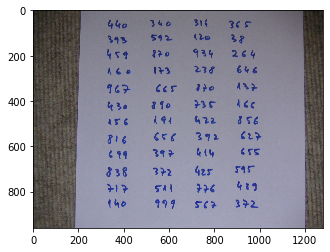

In [2]:
# RULARE PAS1 
#argumentul este pragul de binarizare - acesta trebuie reglat vizual astfel incat 
# in imaginea binarizata sa apara toate caracterele usor recogniscibile

Step1(prag=70)   # Pentru lista completa de parametri vezi mai sus 

# Valoarea optima este 70 pentru imaginea considerata (conform platformei lucrarii se pot incerca mai multe variante)
# Daca alegem alte imagini toti parametrii functiei trebuiesc reconsiderati 
# Incercati diferite valori ale pragului si observati implicatiile pentru pasii 2 si 3 
# Ce se observa in cazul unui prag mic, dar in cazul unuia mare ? 

In [0]:
#  DEFINIRE FUNCTII PAS2 - RETEA CELULAR NEURONALA 
#  Sunt posibile doua implementari :  utilizand JIT (necesita NUMBA), utilizand NUMPY (disponibil pe o diversitate de platforme)
# ----------------------------------------------------------------------------------------------------------------------------------

import time
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from numba import jit
import time as ti
import scipy.misc

#@jit(nopython = True, parallel = True)
@jit 
def sign(a):
    if a < 0:
        return -1
    else:
        return 1


def ncell_array(x0, steps, segm):
# Varianta NUMPY (calcul matricial) pentru implementarea autom. celular     
    x = (x0 + 1) / 2
    
    
    for st in np.arange(steps):
        if segm == 1:
            sigm = 2 * x - 4.5
            si = 1
        else:
            sigm = 4 * (1 - x) - 4.5
            si = -1
        
        w = sigm + (np.roll(x, -1, 0) + np.roll(x, 1, 0) + np.roll(x, -1, 1) + np.roll(x, 1, 1))
        
        
        x = (np.sign(si * w) + 1) / 2
    return x 

# VARIANTA CU COMPILATOR (Just In Time = JIT)
@jit
def cell_array(x0, steps, segm):
    (m, n) = np.shape(x0)
    xt = np.zeros((m, n), 'int8')
    x = np.zeros((m, n), 'int8')
    for i in range(m):
        for j in range(n):
            x[i, j] = (x0[i, j] + 1) / 2
    
    for step in range(steps):
        for i in range(m):
            iu = i + 1 
            if iu == m:
                iu = 0
            id = i - 1
            if id < 0:
                id = (m - 1)
            for j in range(n):
                jr = j + 1
                if jr == n:
                    jr = 0
                jl = j - 1
                if jl < 0:
                    jl = n - 1
                if segm == 1:
                    xt[i, j] = (1 + sign(-9 + 4 * x[i, j] + 2 * (x[iu, j] + x[id, j] + x[i, jl] + x[i, jr]))) / 2
                else:
                    xt[i, j] = (1 - sign(-1 - 8 * x[i, j] + 2 * (x[iu, j] + x[id, j]+x[i, jl] + x[i, jr]))) / 2
        for i in range(m):
            for j in range(n):
                x[i, j] = xt[i, j]
    
    return x


def Step2(iteratii = 50, nume = 'photo1', impl=1 ):
# impl=0 -- implementare cu JIT - functional numai in sisteme PC (presupune instalarea NUMBA ) 
# impl=1 --  implementare NUMPY - poate fi utilizat si pe platforme "embbeded" de ex. R-Pi 

    colmap = 'gray' 
    
    db = sio.loadmat(nume + '.mat')
    X0 = db['x0'].astype('int8')
    
    times = []

    timer = time.time()
    if impl==0:
      z = cell_array(X0, iteratii, 1)  #pune automatul celular la lucru si masoara timpul de executie
    else:
      z = ncell_array(X0, iteratii, 1) 
    runtime = time.time() - timer
    print ("Step2 time phase 1: %f s" % runtime)

    times.append(runtime)

    plt.figure('Obiecte')
    plt.imshow(64 * z, colmap, interpolation = 'none', vmin = np.min(z), vmax = np.max(z))
    plt.axis('off')
    plt.title('procesat dupa: ' + str(iteratii))
    plt.axis('off')
    plt.show()

    imwrite('Obiecte.JPG', 64 * z)
    
    z1 = 2*z-1
    timer = time.time()
    if impl==0:
      z2 = cell_array(z1, 1, 0)
    else:
      z2 = ncell_array(z1, 1, 0)
    runtime = time.time() - timer

    times.append(runtime)
    print ("Step2 time phase 2: %f s" % runtime)

    plt.figure("Rame obiecte")
    plt.imshow(64 * z2, cmap = plt.get_cmap('gray'), vmin = 0, vmax = 63)
    plt.show()

    imwrite('Rame.JPG', 64 * z2)
    
    db = {'x0':z2}  # variabila imagine salvata ca dictionar ptr functia savemat
    sio.savemat('outstep2.mat', db, format = '5') #format = 5 => fisiere db in format matlab5

    return times
 

In [4]:
# IMPLEMENTARE PAS 2 - PRELUCRAREA CU AUTOMAT CELULAR PENTRU LOCALIZAREA ZONELOR DE INTERES

# In cazul implementarii JIT rulati de 2 ori pentru a preveni afisarea unor avertismente 
# Q: Ce valori au timpii de rulare in cele doua cazuri  impl=0/1; Incercati o explicatie 

Step2(iteratii=60, impl=1)
# Q: In ce situatii (platforma de integrare) este necesara implementarea impl=1 ? (Raspberry - Pi are JIT ? )
# Q: Ce se intampla in cazul unui numar prea mic de iteratii, dar in cazul unui numar prea mare ? 
# Care ar fi numarul optim si de cine depinde ? 

Step2 time phase 1: 0.865726 s


Step2 time phase 2: 0.016068 s


[0.8657264709472656, 0.016068458557128906]

In [0]:
# PAS 3 - DEFINITII FUNCTII UTILE (determinarea listei cu cate 4 valori care definesc fiecare caracter )
# Se cauta colturi stanga sus (functia analys) si odata gasit se determina 4 valori care definesc zona utila 
# Apoi, in functia Step3() se face si o reordonare astfel incat sa corespunda parcurgerii firesti 
# in conformitate cu fisierul "etichete"
#---------------------------------------------

import numpy as np
import scipy.io as sio


def indices(a, func):
    return [i for (i, val) in enumerate(a) if func(val)]

def analysis(x0):
# Construieste matricea C cu cele 4 valori numerice pentru fiecare colt stanga sus 
    size = np.shape(x0)
    
    m = size[0]
    n = size[1]
    C = np.array([])
    
    for i in range(m - 1):
        for j in range(n - 1):
            if x0[i, j] == 0:
                if x0[i + 1, j] == 0 and x0[i, j + 1] == 0:
                    ci = i + 1
                    cj = j + 1
                    wi = 0
                    
                    while x0[i + wi, j] == 0:
                        wi += 1
                    
                    wj = 0
                    
                    while x0[i, j + wj] == 0:
                        wj += 1
                    
                    if C.size == 0:
                        C = np.array([ci, cj, wi, wj])
                    else:
                        C = np.vstack((C, np.array([ci, cj, wi, wj])))
    return C


def Step3(ariemin=100):
    x0 = sio.loadmat('outstep2.mat')['x0']
    t1=time.time()
    C = analysis(x0)
    t2=time.time()
    print('Durata proces de analiza:',t2-t1,' secunde')

    A = np.multiply(C[:, 2], C[:, 3])
    A = A[np.newaxis]
    
    # filtreaza (elimina) elementele cu o arie mai mica decat ariemin 
    # 
    ix = indices(A.T, lambda x: x > ariemin)
    C = C[ix, :]


    nc = np.shape(C)[0]
    dm = np.shape(C)[1]
    
    ix = list(range(1, nc))
    ix = np.asarray(ix)
    D = C[ix, 0] - C[ix - 1, 0]
    D = D[np.newaxis]
    D = D.T
    prag = D.max(axis = 0)/2
    
    #detectia de randuri
    D = np.vstack((-1, np.sign(D - prag)))
    rand_nou = indices(D, lambda x: x > 0)
    rand_nou = np.array(rand_nou)
    rand_nou = rand_nou[np.newaxis]
    rand_nou = rand_nou.T
    if rand_nou.size == 0:
        rand_nou = np.array([1])
    else:
        rand_nou = np.vstack((np.array([1]), C[rand_nou, 0]))
    nr_randuri = np.shape(rand_nou)[0]
    
    OC=np.array([])
    
    for j in range(0, nr_randuri - 1):
        st = rand_nou[j]
        en = rand_nou[j + 1]
        R = C[:, 0]
        ix_bloc = indices(R, lambda x: x < en and x >= st)
        bloc = C[ix_bloc, :]
        s = np.sort(bloc[:, 1], axis = 0)
        ix = sorted(range(len(bloc[:, 1])), key = lambda k: bloc[:, 1][k])
        ix = np.array(ix)
        ix = ix[np.newaxis]
        ix = ix.T
        if OC.size == 0:
            OC = bloc[ix, :]
        else:
            OC = np.vstack((OC, bloc[ix, :]))
            
    st = rand_nou[nr_randuri-1]
    R = C[:, 0]
    ix_bloc = indices(R, lambda x: x >= st)
    bloc = C[ix_bloc, :]
    s = np.sort(bloc[:, 1], axis = 0)
    ix = sorted(range(len(bloc[:, 1])), key = lambda k: bloc[:, 1][k])
    ix = np.array(ix)
    ix = ix[np.newaxis]
    ix = ix.T
    if OC.size == 0:
        OC = bloc[ix, :]
    else:
        OC = np.vstack((OC, bloc[ix, :]))
    
    C = OC
    C = np.reshape(C, (np.shape(C)[0], np.shape(C)[2]))
    db = {'C':C}
    sio.savemat('outstep3.mat', db, format = '5')

    a = np.shape(C)[0]
    b = len(s)
    t3=time.time()
    print('Durata rearanjari randuri: ',t3-t2,' secunde')
    return a, b, C
    

In [6]:
# INVOCA PASUL 3 
# Q: de la ce valoare in sus pentru aria minima se "elimina" caractere ??
# Q: de ce in anumite conditii preliminare (pasii 1,2) algoritmul da erori ? 
(a, b, C)=Step3(ariemin=100)
np.shape(C)
print(C) # daca doriti vizualizarea listei 

Durata proces de analiza: 0.38880228996276855  secunde
Durata rearanjari randuri:  0.005028247833251953  secunde
[[ 43  81  40  23]
 [ 45 115  37  23]
 [ 61 145  21  21]
 [ 45 268  30  20]
 [ 47 304  25  16]
 [ 52 339  20  19]
 [ 41 462  31  19]
 [ 47 489  24   7]
 [ 41 508  36  13]
 [ 48 617  34  20]
 [ 50 647  29  18]
 [ 51 686  27  29]
 [114  80  31  24]
 [120 110  32  19]
 [120 138  28  26]
 [108 273  28  26]
 [109 303  30  18]
 [113 334  23  32]
 [104 461  30  12]
 [105 484  27  23]
 [115 509  17  25]
 [108 627  35  23]
 [115 662  33  22]
 [173  77  45  19]
 [185 114  26  19]
 [184 149  33  20]
 [177 278  34  16]
 [180 303  28  19]
 [186 334  19  18]
 [172 459  37  22]
 [176 494  29  22]
 [176 528  35  16]
 [178 629  29  27]
 [179 672  28  19]
 [179 712  36  18]
 [256  80  30  16]
 [256 119  29  19]
 [265 163  17  18]
 [251 284  31  12]
 [252 305  31  25]
 [254 334  30  23]
 [247 464  29  28]
 [250 498  28  18]
 [250 528  32  25]
 [245 652  33  19]
 [248 685  30  18]
 [252 720  27

In [0]:
# FUNCTII PAS 4 
# EXTRACTOR (SIMPLU) DE TRASATURI + SALVARE IN FORMAT LIBSVM PENTRU ANTRENARE 
# H,L REPREZINTA SUBDIVIZUNILE MOD=0 (NUME_TRAIN SI NUME_TEST) MOD=1 (UN SINGUR FISIER NUME.MAT)

import numpy as np
import scipy.io as sio
import math

def Step4(mod = 0, h = 4, l = 3, name='h00'):
# mod=0 (split train/test); mod=1 - salveaza un fisier unic cu toate esantioanele 

    
    C = sio.loadmat('outstep3.mat')['C']
    
    x0 = sio.loadmat('photo1.mat')['x0']
    x0 = (x0+1)/2
    x = x0
    F = np.array([])
    O = []
    
    #h = 3  #customizable scale factor
    #l = 2
    localfile=urllib.request.urlretrieve(lab_path+'etichete.txt')
    with open(localfile[0]) as f:
        txt = f.read().splitlines()
    size = np.shape(txt)
    
    a=[]
    for i in range(0, size[0]):
        for j in range(0, len(txt[i])):
            if txt[i][j] != ' ':
                 a.append(txt[i][j])
    Nlabels = len(a)

    size = np.shape(C)[0]
    
    #later check for no of labels is equal to no of objects in imageRows
    
    
    #conversie labels din string in integers
    if Nlabels != size:
        print('Eroare: numarul de etichete diferit de cel al caracterelor segmentate');
        return None,None
    
    
    for i in range(0, Nlabels):
        O.append(int(a[i]));
    
    O = np.array(O)   
    
    for i in range(size):
        ftemp = np.array([])
        
        ci = C[i, 0]
        cj = C[i, 1]
        wi = C[i, 2]
        wj = C[i, 3]
        
        cha = x0[ci:ci + wi - 1, cj:cj + wj - 1]
        x[ci:ci + wi - 1, cj:cj + wj - 1] = 1 - x0[ci:ci + wi - 1, cj:cj + wj - 1];
#       
        ''' 
        plt.figure('img')
        plt.imshow(x, cmap='gray')
        '''
        nalt = math.floor(wi / h)
        lat = math.floor(wj / l)
        #                                   
        for k1 in range(0, h):
            for k2 in range(0, l):
                q1 = range(1 + (k1 - 1) * nalt, 1 + k1 * nalt - 1)
                q2 = range(1 + (k2 - 1) * lat, 1 + k2 * lat - 1)
                matr = cha[q1, :]
                matr = matr[:, q2]
                ind = np.where(matr == 0)
                xx = np.shape(ind[0])[0]
                if ftemp.size == 0:
                    ftemp = np.array(xx)
                else:
                    ftemp = np.hstack((ftemp,np.array(xx)))
        if F.size == 0:
            F = np.array(ftemp/(nalt*lat))
        else:
            F = np.vstack((F,np.array(ftemp/(nalt*lat))))
    
    k=C[:,3]/C[:,2]
    k = k / (k.max(axis=0))
    
    F = np.transpose(F)
    if F.size==0:
        F = np.array(k)
    else:
        F = np.vstack((F,np.array(k)))
        
    N = np.shape(F)[1]
    
    ixp = np.random.permutation(N)
    F = F[:,ixp]
    
    O = O[ixp]
    
    if mod == 0:
        N1 = round((5 * N) / 8)
        ix1 = range(0, N1)
        Samples = F[:, ix1]
        Labels = O[ix1] + 1
        db = {'Samples':Samples, 'Labels':Labels}
        sio.savemat(name+'_train.mat', db, format = '5')
    
        ix1 = range(N1, N)
        Samples = F[:, ix1]
        Labels = O[ix1] + 1
        db = {'Samples':Samples, 'Labels':Labels}
        sio.savemat(name+'_test.mat', db, format = '5')
    else:
        ix1 = range(N)
        Samples = F[:, ix1];
        Labels = O[ix1] + 1
        db = {'Samples':Samples, 'Labels':Labels}
        sio.savemat(name+'.mat', db, format = '5')
    
    return F, O


In [0]:
# EXECUTIE PAS4 - urmariti formarea fiserelor pentru anternare si validare (test)

F,O=Step4(mod=0, h=4, l=4, name='h70_44')

In [20]:
print(F[:,0:2])
print(O[0:2])

[[0.63636364 0.66666667]
 [0.5        0.43589744]
 [0.51818182 0.14529915]
 [0.16363636 0.30769231]
 [0.81818182 0.28205128]
 [0.41818182 0.55555556]
 [0.48875    0.29853659]]
[5 9]


# **LUCRAREA 2** - CLASIFICATORI, OPTIMIZAREA MODELULUI, ALEGEREA SOLUTIEI OPTIME PENTRU PLATFORMA DE INTEGRARE 

In [0]:
# FUNCTII CLASIFICATOR ELM 
# Adaptate dupa https://github.com/radu-dogaru/ELM-super-fast
# Articolul aici: http://atm.neuro.pub.ro/radu_d/html/09_10/ici2009/col-lab/08453732-ELM.pdf


import numpy as np
import scipy.io as sio
import scipy.linalg
import time as ti

'''
inW = 0
outW = 0
clase = 0
nr_neuroni = 2000
tip = 3
'''

# Implementare functie strat neliniar - 4 tipuri disponibile - posibil optiune selectabila in interfata

def hidden_nonlin(hid_in):
    # hid_in - intrari asociate stratului ascuns.
    global tip
    if tip == 0: # sigmoid
        H = np.tanh(hid_in)
    elif tip == 1: # linsat
        H = abs(1 + hid_in) - abs(1 - hid_in)
    elif tip == 2: # ReLU
        H = abs(hid_in) + hid_in
    elif tip == 3: # modulo
        H = abs(hid_in)
    elif tip == 4: # multiquadric
        H = np.sqrt(hid_in * hid_in + 1)
    return H


# Antrenare a modelului fara cuantizare:
def elmTrain_optim(X, Y, C):
    global nr_neuroni
    global tip
    # X - Vectori de antrenare Y - Etichete
    # C - coeficient de regularizare.
    # tip - tipul functiei asociate stratului ascuns.
    Ntr = np.size(X, 1) # Dimensiunea vectorilor de antrenare.
    in_Neurons = np.size(X, 0) # Nr de vectori de antrenare (neuroni de intrare).
    classes = np.max(Y) # Nr de clase determinat de maximul din lista de etichete.
    # Transformare etichete in matrice coloana
    targets = np.zeros((classes, Ntr), dtype = 'int8')
    for i in range(0, Ntr):
        targets[Y[i] - 1, i] = 1
    targets = targets * 2 - 1

    #   Generare ponderi de intrare in stratul ascuns, in mod aleator.
    rnd = np.random.RandomState() # Seed pentru random
    #   Ponderi intre stratul de intrare si stratul de iesire.
    inW = -1 + 2 * rnd.rand(nr_neuroni, in_Neurons).astype('float32')

    #  Fct neliniara de la iesirea stratului ascuns.
    hid_inp = np.dot(inW, X)
    H = hidden_nonlin(hid_inp)

    # Antrenare efectiva
    outW = scipy.linalg.solve(np.eye(nr_neuroni) / C + np.dot(H, np.transpose(H)), np.dot(H, np.transpose(targets)))

    return inW, outW

# Antrenare a modelului cu cuantizare.
def elmTrain_fix(X, Y, C, ni):
    # X - vectori de intrare Y - etichete
    # ni - nr de biti la care se cuantizeaza ponderile inW
    global tip, nr_neuroni
    Ntr = np.size(X, 1)
    in_Neurons = np.size(X, 0)
    classes = np.max(Y)
    # Transformare etichete in matrice coloana
    targets = np.zeros((classes, Ntr), dtype='int8')
    for i in range(0, Ntr):
        targets[Y[i] - 1, i] = 1
    targets = targets * 2 - 1
    
    # Generare inW layer
    rnd = np.random.RandomState()
    inW = -1 + 2 * rnd.rand(nr_neuroni, in_Neurons).astype('float32')
    
    # Faza de cuantizare pe biti. (salvare de memorie pt sisteme integrate)
    # Cuantizarea realizata pe ponderile de intrare in stratul hidden.
    Qi = -1 + pow(2, ni - 1)
    inW = np.round(inW * Qi)

    #  Computatie a stratului ascuns.
    hid_inp = np.dot(inW, X)
    H = hidden_nonlin(hid_inp)

    # Computatie s iesirii stratului ascuns.
    if nr_neuroni < Ntr:
        #print('LLL - Less neurons than training samples')
        outW = scipy.linalg.solve(np.eye(nr_neuroni)/C+np.dot(H,H.T), np.dot(H,targets.T))     
    else:
        #print('MMM - More neurons than training samples')
        outW = np.dot(H,scipy.linalg.solve(np.eye(Ntr)/C+np.dot(H.T,H), targets.T))
     
    return inW, outW

def elmPredict_optim(X):
    # Functia de predictie. Returneaza o matrice de scoruri.
    
    global tip, inW, outW
    
    hid_in = np.dot(inW, X)
    H = hidden_nonlin(hid_in)
    score = np.transpose(np.dot(np.transpose(H), outW))
    return score


def Setup(nume = 'optd64', neurons = 8000, C = 0.1, typo = 4, nb_in = 2, nb_out = 8, mod = 0):
    # Incarcare baza de date, dupa nume.
    # nb_out = nr de biti de cuantizare la iesire


    global inW, outW, clase
    global nr_neuroni
    global tip
    
    nr_neuroni = neurons
    tip = typo

    times = []
    
    if mod == 0:
        t1 = ti.time()
        db = sio.loadmat(nume + '_train.mat')
        Samples = db['Samples'].astype('float32')
        Labels = db['Labels'].astype('int8')
        clase = np.max(Labels)
        trun = ti.time() - t1
    else:
        t1 = ti.time()
        db = sio.loadmat(nume + '.mat')
        Samples = db['Samples'].astype('float32')
        Labels = db['Labels'].astype('int8')
        clase = np.max(Labels)
        trun = ti.time() - t1
        return None

    times.append(trun)
    #print(" load train data time: %f seconds" % trun)
    
    
    t1 = ti.time()
    if nb_in > 0:  # nb_in determina daca se foloseste cuantizare sau nu.
        inW, outW = elmTrain_fix(Samples, np.transpose(Labels), C, nb_in)
    else:
        inW, outW = elmTrain_optim(Samples, np.transpose(Labels), C)
    trun = ti.time() - t1
    #print(" training time: %f seconds" % trun)

    times.append(trun)
    #print(times)

    # Cuantizare ponderi la iesire din stratul hidden.
    
    Qout = -1 + pow(2, nb_out - 1)
    if nb_out > 0:
        O = np.max(np.abs(outW))
        outW = np.round(outW * (1 / O) * Qout)

    return times
    
def TestFrame(nume = 'optd64', mod = 1, display=1):
    # Validare incarcare dataset
    
    global inW, outW, clase
    global nr_neuroni
    global tip
    
    t1 = ti.time()
    if mod == 0:
        db = sio.loadmat(nume + '_test.mat')
    else:
        db = sio.loadmat(nume + '.mat')

    times = []

    Samples = db['Samples'].astype('float32')
    Labels = db['Labels'].astype('int8')
    n = Samples.shape[0]
    N = Samples.shape[1]
    t2 = ti.time() - t1
    #print(" load test data time: %f seconds" % t2)
    
    times.append(t2)
    
    # Testare acuratete
    
    t1 = ti.time()
    scores = elmPredict_optim(Samples)
    t2 = ti.time() - t1
    #print(" prediction time: %f seconds" % t2)
    
    times.append(t2)
    
    Conf = np.zeros((clase, clase), dtype='int16')
    for i in range(N):
        # gasire pozitie clasa prezisa
        ix = np.nonzero(scores[:, i] == np.max(scores[:, i]))
        
        pred = int(ix[0])
        actual = Labels[0, i] - 1
        Conf[actual, pred] += 1
    accuracy = 100.0 * np.sum(np.diag(Conf)) / np.sum(np.sum(Conf))
    if display==1:
      print("Matrice confuzie:  ")
      print(Conf)
      print("Acuratetea este: %f" % accuracy)
      print("Numar neuroni pe strat ascuns: %d" % nr_neuroni)
      print("Neliniaritate strat ascuns (0=sigmoid; 1=linsat; 2=Relu; 3 - ABS; 4- multiquadric): %d" % tip)

    return times, Conf, accuracy, N
    
    


In [120]:
# ANTRENARE CLASIFICATOR  ELM (o singura incercare)
# nb_in=2 inseamna cuantizare cu 1 bit strat ascuns 
# nb_out=8 inseamna 8 biti virgula fixa pentru parametrii stratului de iesire 

# Rulati codul de mai jos 
# Q: cum se explica obtinerea unor acurateti diferite in incercari diferite ? 
# In masura timpului disponibil puteti incerca reproducerea rezultatelor din articolul citat mai sus (celula anterioara)fisier='h70_43'
fisier='h70_44'
(t1,t2)=Setup(nume =fisier, neurons = 100, C = 1, typo = 3, nb_in = 2, nb_out = 8, mod = 0)
print('Timp incarcare date antrenare: ',t1,'Timp antrenare ELM: ', t2 )
(a, b, acc, N)=TestFrame(nume = fisier, mod=0)
latency=a[1]/N
print('Timp incarcare date antrenament: ',a[0],'Timp predictie (tot setul): ',a[1])
print('Latenta (ms): ', latency*1000 )

model=[inW, outW, tip]

# Parcurgeti pasii 1-4 (lucrarea 1) astfel incat la final sa generati fiserul baza de date 'h02'
# Urmarind tabelul din platforma de laborator asociata lucrarii 2 - generati mai multe baze de date pentru 
# variante diferite privind valorile prag (pasul 1) si (h,l) pasul 4 (numarul de iteratii in pasul 2 ramane mereu 60)
# # Nota: puteti diviza sarcina (fiecare student isi alege setul propriu de parametri).
# Cu ajutorul codului de mai jos gasiti acuratea cea mai buna si modelul optim (numarul cel mai mic de neuroni sau vectori suport)


# Implementati o functie care permite identificarea celui mai "bun" (Acuratete cat mai mare) model - rezolvat mai jos 
# Daca nu aveti la dispozitie acea functie - rulati de cel putin 10 ori si salvati best_model=model ori de cate ori constatatati cresterea acuratetii
# Urmariti latenta in cazul ELM (pentru comparatii ulterioare cu alte implementari)
# Care este principala problema (dezavantaj) in cazul ELM ?  

Timp incarcare date antrenare:  0.001210927963256836 Timp antrenare ELM:  0.005408048629760742
Matrice confuzie:  
[[4 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 1 0 4 0 0 0 0 0 0]
 [0 1 0 0 6 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 8 0 0 0]
 [0 0 0 0 0 0 0 7 0 0]
 [0 0 0 0 0 0 0 1 3 0]
 [0 1 0 0 0 0 0 0 0 5]]
Acuratetea este: 92.592593
Numar neuroni pe strat ascuns: 100
Neliniaritate strat ascuns (0=sigmoid; 1=linsat; 2=Relu; 3 - ABS; 4- multiquadric): 3
Timp incarcare date antrenament:  0.0003993511199951172 Timp predictie (tot setul):  0.0001163482666015625
Latenta (ms):  0.0021545975296585647


In [127]:
# Bucla pentru cautarea solutiei optime 
# Incercati optimizarea solutiei ca si numar de neuroni (incercati cu 20, 30, 50, etc. )
# Incercati apoi si cateva valori diferite pentru C=0.01 0.1 1 10 100 ..
iteratii=100
fisier='h70_44'
best_acc=0

for i in range(iteratii):
  Setup(nume = fisier, neurons = 80, C = 1, typo = 3, nb_in = 2, nb_out = 8, mod = 0)
  (a, b, acc, N)=TestFrame(nume = fisier, mod=0, display=0)
  if acc>best_acc:
    best_acc=acc
    best_model=[inW, outW, tip]
    best_iter=i
    
print('Acuratetea maxima: ', best_acc,'%', 'obtinuta dupa iteratia: ', best_iter)
# Verificarea modelului optim
[inW, outW, tip]=best_model
(a, b, acc, N)=TestFrame(nume = fisier, mod=0)
latency=a[1]/N
print('Latenta (ms): ', latency*1000 )



Acuratetea maxima:  100.0 % obtinuta dupa iteratia:  17
Matrice confuzie:  
[[4 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 7 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 8 0 0 0]
 [0 0 0 0 0 0 0 7 0 0]
 [0 0 0 0 0 0 0 0 4 0]
 [0 0 0 0 0 0 0 0 0 6]]
Acuratetea este: 100.000000
Numar neuroni pe strat ascuns: 80
Neliniaritate strat ascuns (0=sigmoid; 1=linsat; 2=Relu; 3 - ABS; 4- multiquadric): 3
Latenta (ms):  0.0014216811568648726


In [101]:
# Vizualizare elemente model. Care sunt avanatajele din perspectiva integrarii ? 

print(model[1]) # inlocuiti apoi 0 cu 1 si respectiv 2 
# Modelul ELM consta numai din aceste 3 elemente si poate fi convenabil integrat pe platforme care 
# suporta numar finit de biti (1-8). Modelul rezultat in urma antrenarii SVM necesita implementarea in 
# virgula mobila. 

[[ -15.  -21.   23.  -18.   15.  -10.  -19.  -15.   31.   20.]
 [   2.   22.   15.  -47.  -19.    4.   43.   43.   -0.   28.]
 [  30.    6.  -39.   -0.  -17.  -20.  -39.  -57.   18.   41.]
 [   0.   16.  -44.   18.  -19.   -1.  -10.  -27.   14.  -14.]
 [ -22.   -0.    4.  -26.   -5.   17.   -7.   15.  -41.   27.]
 [  -0.   24.    2.   14.   65.   28.  -44.  -32.   55.   31.]
 [ -19.   46.   10.   -7.  -22.   32.    1.   66.  -48.   10.]
 [ -24.  -20.   13.  -29.   20.   -8.   21. -105.   11.  -15.]
 [  -4.  -32.  -20.    9.   30.   46.   -9.   10.   19.   -2.]
 [ -29.   91.   20.  -52.  -17.  -49.  -46.  -50.    1.  -42.]
 [ -30.   34.   10.  -13.   13.  -20.  -35.  -15.    5.  -40.]
 [ -20.   22.  -16.   16.   31.   10.   -6.   25.  -14.   -7.]
 [ -28.  -55.   -2.  -49.   -9.   -5.   40.   11.   14.   58.]
 [ -20.   30.   -8.   -9.   16.   -0.   -6.   14.  -44.  -14.]
 [   5.  -61.   35.   22.   28.   37.  -11.   -1.   34.   36.]
 [  24.  -12.    9.  -14.  -22.  -10.   13.   -9.  -29.

In [0]:
# CLASIFICATOR SVM 
# Functii implementare 


"""
Created on Wed Apr 18 15:46:56 2018

@author: Radu Dogaru 
Implementare SVM SciKit cu date in format LIBSVM 
18 aprilie 2018 
"""

import numpy as np 
import time 
from sklearn.svm import SVC
import scipy.io as sio

def SVM_train(nucleu='linear', C=1, gamma=1, nume='h00'):
  # Nucleu -  It must be one of ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’ or a callable. If none is given, ‘rbf’ will be used
  # constructie model SVM 
  clf = SVC(C=C, gamma=gamma, kernel=nucleu)
  #Incarca si pregateste date de antrenare 
  timer = time.time()
  db=sio.loadmat(nume+'_train.mat')
  Samples=db['Samples'].astype('float32')
  Samples=Samples.T
  print('esantioane antrenare', np.shape(Samples))
  Labels=db['Labels'].astype('int8')
  N=np.size(Samples,0)
  n=np.size(Samples,0)
  M=np.max(Labels)
  runtime = time.time() - timer
  print( "Timp incarcare date antrenament: %f s" % runtime)
  y=np.reshape(Labels-1,N)
  # Antreneaza 
  # Poate dura foarte mult la MNIST !!! 
  timer = time.time()
  clf.fit(Samples,y)
  runtime = time.time() - timer
  print( "Timp antrenare: %f s" % runtime)
  return clf 

def SVM_test(model, nume='h00'):
  # Incarca set de validare 
  timer = time.time()
  db=sio.loadmat(nume+'_test.mat')
  Samples=db['Samples'].astype('float32')
  Samples=Samples.T

  Labels=db['Labels'].astype('int8')
  N=np.size(Samples,0)
  n=np.size(Samples,0)
  M=np.max(Labels)
  runtime = time.time() - timer
  print( "Timp incarcare set test: %f s" % runtime)
  y=np.reshape(Labels-1,N)
  timer = time.time()
  Acc=model.score(Samples, y)
  runtime = time.time() - timer
  print( "Timp set test: %f s" % runtime)
  print("Acuratetea: %f" %Acc)
  print('Latenta: (ms): ', 1000*runtime/N)
  nsv=np.shape(model.support_vectors_)
  print( "Numar vectori suport: %d" %nsv[0])
  return Acc



In [132]:
#  OPTIMIZARE PARAMETRI - CLASIFICATOR SVM  
# Rulati programnul de mai jos pentru identificarea modelului optim 
# notati in tabelul asociat (cf. platformei de laborator) valorile acuratetii, numar SV si latenta 
# Sunt ultimele 3 valori afisate 
# Q: cum se compara latenta cu cea obtinuta in cazul ELM ? 
# Q: care dintre modele considerati ca este mai eficient pentru o implementare in hardware ? de ce ? 
tipker='rbf' # tip nucleu (linear sau rbf = Gaussian)
if tipker=='rbf':
  rg=[0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5]  # valori gamma incercate 
elif tipker=='linear':
  rg=[1]  # nu mai este necesar parametrul gamma 

rC=[1, 2, 5, 10, 20, 50]  # Valori C incercate 
BestAcc=0
for gam in rg:
  for C_ in rC:
    curent_model=SVM_train(nucleu=tipker, C=C_, gamma=gam, nume=fisier)
    Acc=SVM_test(curent_model, nume=fisier)
    if Acc>BestAcc:
      BestAcc=Acc
      gamopt=gam
      Copt=C_
      best_model=curent_model
print('Cea mai buna acuratete: ',BestAcc*100,'% pentru Gamma=',gamopt,' Copt=',Copt)
Acc=SVM_test(best_model, nume=fisier)

esantioane antrenare (89, 17)
Timp incarcare date antrenament: 0.004980 s
Timp antrenare: 0.002396 s
Timp incarcare set test: 0.000524 s
Timp set test: 0.001179 s
Acuratetea: 0.240741
Latenta: (ms):  0.021841790941026475
Numar vectori suport: 89
esantioane antrenare (89, 17)
Timp incarcare date antrenament: 0.001115 s
Timp antrenare: 0.001676 s
Timp incarcare set test: 0.000288 s
Timp set test: 0.000654 s
Acuratetea: 0.240741
Latenta: (ms):  0.012106365627712674
Numar vectori suport: 89
esantioane antrenare (89, 17)
Timp incarcare date antrenament: 0.000479 s
Timp antrenare: 0.001642 s
Timp incarcare set test: 0.000259 s
Timp set test: 0.000821 s
Acuratetea: 0.407407
Latenta: (ms):  0.015205807156032987
Numar vectori suport: 89
esantioane antrenare (89, 17)
Timp incarcare date antrenament: 0.000554 s
Timp antrenare: 0.001754 s
Timp incarcare set test: 0.000259 s
Timp set test: 0.000740 s
Acuratetea: 0.759259
Latenta: (ms):  0.013700237980595342
Numar vectori suport: 88
esantioane antre

In [50]:
# Cum se compara latenta cu cea obtinuta in cazul ELM ?
# Dar complexitatea modelului ? 

best_model
# Incercati sa construiti o functie care va afiseaza matricea de confuzie pentru 
# situatia clasifcatorului optim. 
# Incercati rularea codului L1 si L2 pe pltaforme Raspberry - Pi. 
# Care sunt efectele ? In special cu privire la timpii de rulare 

SVC(C=20, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.5, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [51]:
curent_model.get_params()

{'C': 50,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 5,
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}